In [9]:
import numpy as np
from Environment import *
import matplotlib.pyplot as plt
from Model.Evaluator.GraphEvaluator import *
from Learner.UCB_Step4 import *
from Learner.UCB_Step5 import *
from Learner.UCB_SlidingWindow import *
from Model.ConfigurationParametersAverage import mergeUserClasses

In [10]:
files = ['./Configs/config1.json', './Configs/config3.json', './Configs/configuration4.json', './Configs/configuration5.json']
#files = ['./Configs/config1.json', './Configs/configuration5.json']
env = []
config_margins = []
optimal_arms = []
conv_rates = []
prod_lists = []
click_probs = []
lambdas = []
alphas = []
units_means = []
clairvoyant_opt_rew = []
actual_unit_mean = []

n_loops = 1

for i in range(0, len(files)):
    env.append(Environment(config_path=files[i]))
    config = mergeUserClasses([files[i]], False)[0]
    config_margins.append(config["marginsPerPrice"])
    optimal_arms.append(config["optimalConfig"])
    conv_rates.append(config["conversionRateLevels"])
    prod_lists.append(config["productList"])
    print("ProdList={}, Alphas={}, ConvRates={}".format(len(config["productList"]),len(config["alphas"]),len(config["conversionRateLevels"])))
    click_probs.append(config["click_prob"])
    lambdas.append(config['lambda_p'])
    alphas.append(config["alphas"])
    clairvoyant_opt_rew.append(config["optimalMargin"])
    units_means.append(config["units_mean"])
    actual_unit_mean.append(config["actual_units_mean"])

#print(np.multiply(config_margins[0], conv_rates[0]))
#print(actual_unit_mean)
print(click_probs[0])

ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5
[[0.0, 0.5, 0.6, 0.0, 0.0], [0.0, 0.0, 0.4, 0.0, 0.2], [0.0, 0.0, 0.0, 0.8, 0.7], [0.6, 0.0, 0.0, 0.0, 0.5], [0.0, 0.9, 0.0, 0.3, 0.0]]


Running config number  0
[[0.         0.36256    0.39719626 0.         0.59968   ]
 [0.03028634 0.         0.33086635 0.61002522 0.18001261]
 [0.33855981 0.         0.         0.54654655 0.27293844]
 [0.31246793 0.         0.54925603 0.         0.43135662]
 [0.25251743 0.4922109  0.         0.20161774 0.        ]]
[1, 2] 0
[2, 4] 1
[3, 4] 2
[4, 0] 3
[1, 3] 4
[[0.         0.36842105 0.21052632 0.         0.59968   ]
 [0.03028634 0.         0.25       0.61002522 0.01785714]
 [0.33855981 0.         0.         0.84615385 0.33333333]
 [0.46511628 0.         0.54925603 0.         0.34883721]
 [0.25251743 0.72916667 0.         0.10416667 0.        ]]
[[0.         0.36842105 0.21052632 0.         0.59968   ]
 [0.03028634 0.         0.25       0.61002522 0.01785714]
 [0.33855981 0.         0.         0.84615385 0.33333333]
 [0.46511628 0.         0.54925603 0.         0.34883721]
 [0.25251743 0.72916667 0.         0.10416667 0.        ]]
[1, 2] 0
[2, 4] 1
[3, 4] 2
[4, 0] 3
[1, 3] 4
[[0.        

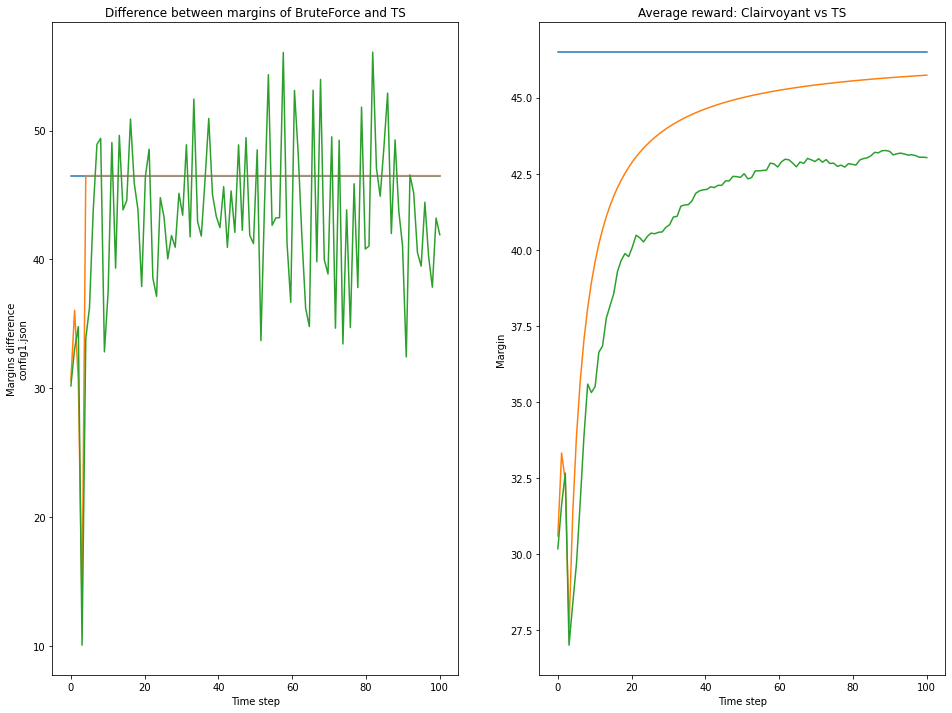

In [11]:
n_experiments = 100
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(16,12))

i = 0  #Choose env 0 to 3
print ("Running config number ", i)
#Other UCB learner need fixing
#learner = UCB_CR(margins=config_margins[i], clickProbability=click_probs[i], alphas=alphas[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False, units_mean=actual_unit_mean[i])

#learner = UCB_Step4(margins=config_margins[i], clickProbability=click_probs[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False)

learner = UCB_Step5(margins=config_margins[i], alphas=alphas[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False, units_mean=units_means[i], conversion_rates=conv_rates[i])

ts_learner_graph_margins = np.array([])
ts_learner_env_margins = np.array([])

for j in range(0, n_experiments):
    ts_single_margin = 0
    opt_single_margin = 0
    armMargins = []
    armConvRates = []

    # compute the margin for the TS
    pulledArm = learner.pull_arm()
    #print (pulledArm)
    for k in range(0, len(pulledArm)):
        armMargins.append(config_margins[i][k][pulledArm[k]])
        armConvRates.append(conv_rates[i][k][pulledArm[k]])

    graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=actual_unit_mean[i], verbose=False, convert_units=False)

    env[i].setPriceLevels(pulledArm)
    ts_interactions = env[i].round()
    ts_single_margin = graphEval.computeMargin()
    #print(ts_single_margin)

    ts_env_margin = 0
    for k in range(0,len(ts_interactions)):
        # ts_env_margin = 0
        ts_env_margin = ts_env_margin + ts_interactions[k].linearizeMargin(config_margins[i])
    ts_env_margin = ts_env_margin / len(ts_interactions)

    learner.update(ts_interactions)

    ts_learner_graph_margins = np.append(ts_learner_graph_margins, ts_single_margin)
    ts_learner_env_margins = np.append(ts_learner_env_margins, ts_env_margin)

opt_arms = optimal_arms[i]
armMargins = []
armConvRates = []
for k in range(0, len(opt_arms)):
    armMargins.append(config_margins[i][k][opt_arms[k]])
    armConvRates.append(conv_rates[i][k][opt_arms[k]])
graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=actual_unit_mean[i], verbose=False, convert_units=False)

# optimal = np.full((n_experiments), clairvoyant_opt_rew[i])
optimal = np.full((n_experiments), graphEval.computeMargin())

config_name = files[i][files[i].rfind('/')-len(files[i])+1:]

x = np.linspace(0, n_experiments, n_experiments)
axes[0].plot(x, optimal)
axes[0].plot(x, ts_learner_graph_margins)
axes[0].plot(x, ts_learner_env_margins)
axes[0].set_xlabel("Time step")
axes[0].set_ylabel("Margins difference\n{}".format(config_name))
axes[0].set_title("Difference between margins of BruteForce and TS")

axes[1].plot(x,optimal)
cum_rews_graph = np.cumsum(ts_learner_graph_margins)
avg_cum_rews_graph = np.divide(cum_rews_graph, np.arange(1,n_experiments+1))
axes[1].plot(x, avg_cum_rews_graph)
cum_rews = np.cumsum(ts_learner_env_margins)
avg_cum_rews = np.divide(cum_rews, np.arange(1,n_experiments+1))
axes[1].plot(x, avg_cum_rews)
axes[1].set_xlabel("Time step")
axes[1].set_ylabel("Margin")
axes[1].set_title("Average reward: Clairvoyant vs TS")
print("Optimal arm found:\n\t", learner.pull_arm(), "\nOptimal theoretical arm:\n\t", optimal_arms[i])

plt.show()

[[0.         0.45467128 0.39861592 0.         0.60702772]
 [0.         0.         0.33741705 0.61351604 0.0862685 ]
 [0.32867598 0.         0.         0.74688797 0.42560759]
 [0.4120983  0.         0.54923193 0.         0.43194707]
 [0.         0.72450805 0.         0.13357185 0.        ]]
[1, 2] 0
[2, 4] 1
[3, 4] 2
[4, 0] 3
[1, 3] 4
[[0.         0.45417237 0.3994528  0.         0.60702772]
 [0.         0.         0.33870156 0.61351604 0.08656266]
 [0.32867598 0.         0.         0.74649533 0.42348131]
 [0.40875233 0.         0.54923193 0.         0.4310987 ]
 [0.         0.72395527 0.         0.13419659 0.        ]]
up [[0.         0.53243441 0.47771485 0.         0.60702772]
 [0.         0.         0.405833   0.61351604 0.15369409]
 [0.32867598 0.         0.         0.81881776 0.49580374]
 [0.50006325 0.         0.54923193 0.         0.52240962]
 [0.         0.79655386 0.         0.20679518 0.        ]]
[[0.         0.45417237 0.3994528  0.         0.60702772]
 [0.         0.      

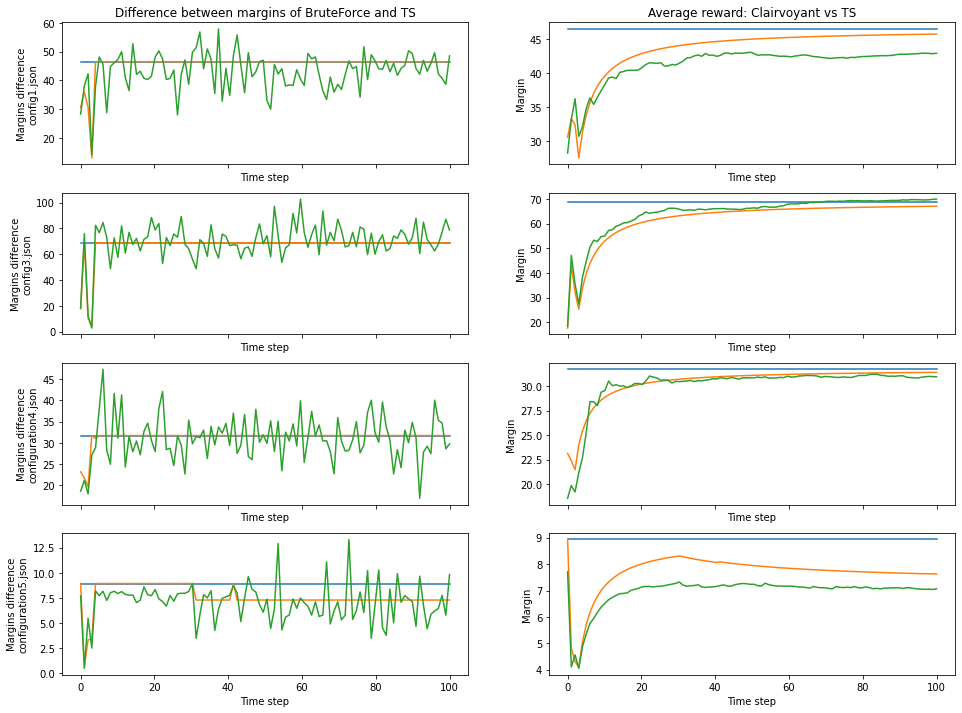

Running config number  0
[[0.         0.425119   0.30428415 0.         0.59968   ]
 [0.03028634 0.         0.33624801 0.61002522 0.06465289]
 [0.33855981 0.         0.         0.74054719 0.30525669]
 [0.35424114 0.         0.54925603 0.         0.43743906]
 [0.25251743 0.69744704 0.         0.08745247 0.        ]]
[1, 2] 0
[2, 4] 1
[3, 4] 2
[4, 0] 3
[1, 3] 4
[[0.         0.60869565 0.30434783 0.         0.59968   ]
 [0.03028634 0.         0.35384615 0.61002522 0.09230769]
 [0.33855981 0.         0.         0.75609756 0.29268293]
 [0.25641026 0.         0.54925603 0.         0.48717949]
 [0.25251743 0.57446809 0.         0.10638298 0.        ]]
[[0.         0.60869565 0.30434783 0.         0.59968   ]
 [0.03028634 0.         0.35384615 0.61002522 0.09230769]
 [0.33855981 0.         0.         0.75609756 0.29268293]
 [0.25641026 0.         0.54925603 0.         0.48717949]
 [0.25251743 0.57446809 0.         0.10638298 0.        ]]
[1, 2] 0
[2, 4] 1
[3, 4] 2
[4, 0] 3
[1, 3] 4
[[0.        

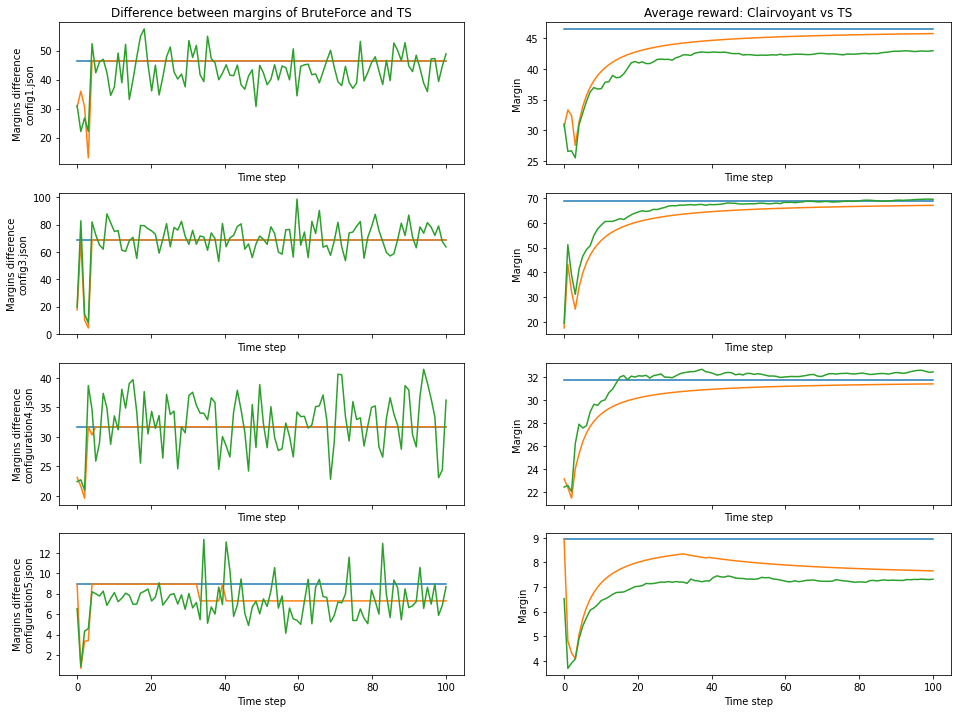

In [12]:
n_experiments = 100
fig, axes = plt.subplots(ncols=2, nrows=len(env), sharex=True, figsize=(16,12))

for i in range(0, len(env)):
    print ("Running config number ", i)
    #Other UCB learner need fixing
    #learner = UCB_CR(margins=config_margins[i], clickProbability=click_probs[i], alphas=alphas[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False, units_mean=actual_unit_mean[i])

    #learner = UCB_Step4(margins=config_margins[i], clickProbability=click_probs[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False)

    learner = UCB_Step5(margins=config_margins[i], alphas=alphas[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False, units_mean=units_means[i], conversion_rates=conv_rates[i])

    ts_learner_graph_margins = np.array([])
    ts_learner_env_margins = np.array([])

    for j in range(0, n_experiments):
        ts_single_margin = 0
        opt_single_margin = 0
        armMargins = []
        armConvRates = []

        # compute the margin for the TS
        pulledArm = learner.pull_arm()
        #print (pulledArm)
        for k in range(0, len(pulledArm)):
            armMargins.append(config_margins[i][k][pulledArm[k]])
            armConvRates.append(conv_rates[i][k][pulledArm[k]])

        graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=actual_unit_mean[i], verbose=False, convert_units=False)

        env[i].setPriceLevels(pulledArm)
        ts_interactions = env[i].round()
        ts_single_margin = graphEval.computeMargin()
        #print(ts_single_margin)

        ts_env_margin = 0
        for k in range(0,len(ts_interactions)):
            # ts_env_margin = 0
            ts_env_margin = ts_env_margin + ts_interactions[k].linearizeMargin(config_margins[i])
        ts_env_margin = ts_env_margin / len(ts_interactions)

        learner.update(ts_interactions)

        ts_learner_graph_margins = np.append(ts_learner_graph_margins, ts_single_margin)
        ts_learner_env_margins = np.append(ts_learner_env_margins, ts_env_margin)

    opt_arms = optimal_arms[i]
    armMargins = []
    armConvRates = []
    for k in range(0, len(opt_arms)):
        armMargins.append(config_margins[i][k][opt_arms[k]])
        armConvRates.append(conv_rates[i][k][opt_arms[k]])
    graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=actual_unit_mean[i], verbose=False, convert_units=False)

    # optimal = np.full((n_experiments), clairvoyant_opt_rew[i])
    optimal = np.full((n_experiments), graphEval.computeMargin())

    config_name = files[i][files[i].rfind('/')-len(files[i])+1:]

    x = np.linspace(0, n_experiments, n_experiments)
    axes[i,0].plot(x, optimal)
    axes[i,0].plot(x, ts_learner_graph_margins)
    axes[i,0].plot(x, ts_learner_env_margins)
    axes[i,0].set_xlabel("Time step")
    axes[i,0].set_ylabel("Margins difference\n{}".format(config_name))
    axes[0,0].set_title("Difference between margins of BruteForce and TS")

    axes[i,1].plot(x,optimal)
    cum_rews_graph = np.cumsum(ts_learner_graph_margins)
    avg_cum_rews_graph = np.divide(cum_rews_graph, np.arange(1,n_experiments+1))
    axes[i,1].plot(x, avg_cum_rews_graph)
    cum_rews = np.cumsum(ts_learner_env_margins)
    avg_cum_rews = np.divide(cum_rews, np.arange(1,n_experiments+1))
    axes[i,1].plot(x, avg_cum_rews)
    axes[i,1].set_xlabel("Time step")
    axes[i,1].set_ylabel("Margin")
    axes[0,1].set_title("Average reward: Clairvoyant vs TS")
    print("Optimal arm found:\n\t", learner.pull_arm(), "\nOptimal theoretical arm:\n\t", optimal_arms[i])

plt.show()

In [13]:
#learners = UCB_CR(margins=config_margins[i], clickProbability=click_probs[i], alphas=alphas[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False)
#learner = UCB_Step4(margins=margins, clickProbability=clickProb, secondary=secondary, Lambda=Lambda, debug=True)
#learner = UCB_Step5(margins=margins, alphas=alphas, conversion_rates=conversionRates, secondary=secondary, Lambda=Lambda, debug=True)
#learner = UCB_SlidingWindow(margins=margins, clickProbability=clickProb, alphas=alphas, secondary=secondary, Lambda=Lambda, debug=False)